###  Цели и задачи проекта:
- Анализ продаж игр интернет магазина
- Определить закономерности определяющие успешность игр
- Прогноз продаж на 2017 год

In [1]:
#!pip install fuzzywuzzy
#!pip install python-Levenshtein
#!pip install tqdm
#!pip install scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import difflib
import warnings
from scipy import stats as st
import sys

###  Откроем файл и изучим общую информацию

In [3]:
path = '/datasets/games.csv'
games_df = pd.read_csv(path)
games_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games_df_shape_old = games_df.shape


###  Подготовка данных

####  Приведем названия столбцов к нижнему регисту.

In [6]:
games_df.columns = games_df.columns.str.lower()

####  Рассмотрим уникальные названия платформ.

In [7]:
games_df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

написания одной консоли несколькоми вариантами не замечено.

####  Рассмотрим названия игр

In [8]:
#количество незаполненных названий игр
games_df[games_df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Данных мало, можно удалить данные строки

In [9]:
games_df[games_df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
games_df.dropna( subset = ['name'],inplace=True)

In [11]:
#Проверим нет ли ошибок в использовании строчных и прописных букв
print(len(games_df['name'].unique()))
print(len(games_df['name'].str.lower().unique()))

11559
11559


In [12]:
#проверим возможные опечатки в названиях игр
name_list_lower = games_df['name'].str.lower().unique().tolist()

for i in name_list_lower:

    name_list_lower.remove(i)
    compare = difflib.get_close_matches(i, name_list_lower, cutoff=.98)
    if len(compare) != 0:
        df = (
            games_df[((games_df['name'].str.lower().isin(compare)) &
            (games_df['platform'].isin(games_df[games_df['name'].str.lower() == i]['platform'])))]
        )
        if len(df) !=0:
            
            df = (
            games_df[((games_df['name'].str.lower().isin(compare)) &
            (games_df['platform'].isin(games_df[games_df['name'].str.lower() == i]['platform'])))
                    | (games_df['name'].str.lower() == i)]
            )
            print(i,compare)
            display(df)
        


    

spongebob squarepants: game boy advance video volume 2 ['spongebob squarepants: game boy advance video volume 3', 'spongebob squarepants: game boy advance video volume 1']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3159,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,0.46,0.17,0.0,0.01,NaN,NaN,NaN
3755,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,0.38,0.14,0.0,0.01,NaN,NaN,NaN
7476,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004.0,Misc,0.15,0.05,0.0,0.00,NaN,NaN,NaN


sid meier's civilization vi ["sid meier's civilization v"]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1078,Sid Meier's Civilization V,PC,2010.0,Strategy,0.98,0.52,0.0,0.17,90.0,7.9,E10+
6753,Sid Meier's Civilization VI,PC,2016.0,Strategy,0.09,0.13,0.0,0.02,88.0,7.3,E10+


disney's magical quest starring mickey and minnie ["disney's magical quest 2 starring mickey and minnie"]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7252,Disney's Magical Quest Starring Mickey and Minnie,GBA,2002.0,Action,0.16,0.06,0.0,0.0,NaN,NaN,NaN
12315,Disney's Magical Quest 2 Starring Mickey and M...,GBA,2003.0,Action,0.05,0.02,0.0,0.0,63.0,tbd,E


kouchuu ouja mushi king: greatest champion e no michi ds ['kouchuu ouja mushi king: greatest champion e no michi ds 2']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7729,Kouchuu Ouja Mushi King: Greatest Champion e n...,DS,2005.0,Action,0.0,0.0,0.19,0.0,NaN,NaN,NaN
9408,Kouchuu Ouja Mushi King: Greatest Champion e n...,DS,2006.0,Action,0.0,0.0,0.13,0.0,NaN,NaN,NaN


sid meier's civilization iv ["sid meier's civilization v"]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1078,Sid Meier's Civilization V,PC,2010.0,Strategy,0.98,0.52,0.0,0.17,90.0,7.9,E10+
8464,Sid Meier's Civilization IV,PC,2005.0,Strategy,0.02,0.12,0.0,0.03,94.0,8.3,E10+


kidou senshi gundam: giren no yabou - axis no kyoui ['kidou senshi gundam: giren no yabou - axis no kyoui v']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8656,Kidou Senshi Gundam: Giren no Yabou - Axis no ...,PSP,2008.0,Strategy,0.0,0.0,0.16,0.0,NaN,NaN,NaN
11915,Kidou Senshi Gundam: Giren no Yabou - Axis no ...,PSP,2009.0,Strategy,0.0,0.0,0.07,0.0,NaN,NaN,NaN


romance of the three kingdoms x ['romance of the three kingdoms xi', 'romance of the three kingdoms ix']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10982,Romance of the Three Kingdoms X,PS2,2005.0,Strategy,0.04,0.03,0.00,0.01,71.0,8.5,T
11887,Romance of the Three Kingdoms XI,PS2,2007.0,Strategy,0.00,0.00,0.07,0.00,69.0,8.4,E10+
11980,Romance of the Three Kingdoms IX,PS2,2003.0,Strategy,0.03,0.03,0.00,0.01,74.0,8.9,E


pachitte chonmage tatsujin 13: pachinko hissatsu shigotojin iii ['pachitte chonmage tatsujin 16: pachinko hissatsu shigotojin iii']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11300,Pachitte Chonmage Tatsujin 13: Pachinko Hissat...,PS2,2007.0,Misc,0.0,0.0,0.08,0.0,NaN,NaN,NaN
16160,Pachitte Chonmage Tatsujin 16: Pachinko Hissat...,PS2,2010.0,Misc,0.0,0.0,0.01,0.0,NaN,NaN,NaN


pq: practical intelligence quotient ['pq2: practical intelligence quotient']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11716,PQ: Practical Intelligence Quotient,PSP,2005.0,Puzzle,0.07,0.0,0.0,0.01,69.0,tbd,E
13210,PQ2: Practical Intelligence Quotient,PSP,2006.0,Puzzle,0.04,0.0,0.0,0.00,74.0,7.8,E


tv anime idolm@ster: cinderella girls g4u! pack vol.9 ['tv anime idolm@ster: cinderella girls g4u! pack vol.8', 'tv anime idolm@ster: cinderella girls g4u! pack vol.7', 'tv anime idolm@ster: cinderella girls g4u! pack vol.6']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14947,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2016.0,Misc,0.0,0.0,0.03,0.0,NaN,NaN,NaN
15013,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Adventure,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15452,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Misc,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15620,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2016.0,Misc,0.0,0.0,0.02,0.0,NaN,NaN,NaN


tv anime idolm@ster: cinderella girls g4u! pack vol.7 ['tv anime idolm@ster: cinderella girls g4u! pack vol.8', 'tv anime idolm@ster: cinderella girls g4u! pack vol.6', 'tv anime idolm@ster: cinderella girls g4u! pack vol.5']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15013,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Adventure,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15452,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Misc,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15552,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15620,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2016.0,Misc,0.0,0.0,0.02,0.0,NaN,NaN,NaN


tv anime idolm@ster: cinderella girls g4u! pack vol.5 ['tv anime idolm@ster: cinderella girls g4u! pack vol.8', 'tv anime idolm@ster: cinderella girls g4u! pack vol.6', 'tv anime idolm@ster: cinderella girls g4u! pack vol.4']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15013,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Adventure,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15552,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15620,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2016.0,Misc,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15836,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


tv anime idolm@ster: cinderella girls g4u! pack vol.3 ['tv anime idolm@ster: cinderella girls g4u! pack vol.8', 'tv anime idolm@ster: cinderella girls g4u! pack vol.6', 'tv anime idolm@ster: cinderella girls g4u! pack vol.4']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15013,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Adventure,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15620,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2016.0,Misc,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15811,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN
15836,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


Опечаток с коэффициентом 0.98 не обнаружено

#### Рассмотрим незаполненные годы выхода игр

In [13]:
games_df[games_df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [14]:
# Если в названии игры указан год, укажем этот год в качестве даты выхода
year_of_release_list = pd.Series(games_df['year_of_release'].unique())
year_of_release_set = set(str(int(i)) for i in year_of_release_list[~ year_of_release_list.isna()])

for i in year_of_release_set:
    games_df.loc[(games_df['name'].str.contains(i)) & (games_df['year_of_release'].isna()) , ['year_of_release']] = int(i)
    
games_df['year_of_release'].isna().sum()

252

In [15]:
#Заполним пропущенные значения медианными значениями выхода на других платформах
games_df['year_of_release'].fillna(games_df.groupby('name')['year_of_release'].transform('median'), inplace = True)
games_df['year_of_release'].isna().sum()

139

Удалим оставшиеся пропуски

In [19]:
games_df.dropna(subset=['year_of_release'],inplace=True)
games_df['year_of_release'].isna().sum()


0

In [20]:
#Преобразуем тип данных года выпуска в int
games_df['year_of_release'] = games_df['year_of_release'].astype('int')

In [21]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16574 non-null  object 
 1   platform         16574 non-null  object 
 2   year_of_release  16574 non-null  int64  
 3   genre            16574 non-null  object 
 4   na_sales         16574 non-null  float64
 5   eu_sales         16574 non-null  float64
 6   jp_sales         16574 non-null  float64
 7   other_sales      16574 non-null  float64
 8   critic_score     8079 non-null   float64
 9   user_score       9938 non-null   object 
 10  rating           9871 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


####  Рассмотрим оценки игр

Рейтинг от пользователей

In [22]:
games_df[games_df['user_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [23]:
games_df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [24]:
#имеется значение tbd, скорее всего означает to be determined (будет определен позднее)
games_df[games_df['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [25]:
#заменим его на NaN
games_df.loc[games_df['user_score'] == 'tbd','user_score'] = np.nan
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16574 non-null  object 
 1   platform         16574 non-null  object 
 2   year_of_release  16574 non-null  int64  
 3   genre            16574 non-null  object 
 4   na_sales         16574 non-null  float64
 5   eu_sales         16574 non-null  float64
 6   jp_sales         16574 non-null  float64
 7   other_sales      16574 non-null  float64
 8   critic_score     8079 non-null   float64
 9   user_score       7543 non-null   object 
 10  rating           9871 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [26]:
games_df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 13.])

In [27]:
print(games_df['user_score'].isna().sum())
print(games_df['critic_score'].isna().sum())

9031
8495


In [38]:
#Исправим типы user_score
games_df['user_score'] = games_df['user_score'].astype(float)

In [39]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16574 non-null  object 
 1   platform         16574 non-null  object 
 2   year_of_release  16574 non-null  int64  
 3   genre            16574 non-null  object 
 4   na_sales         16574 non-null  float64
 5   eu_sales         16574 non-null  float64
 6   jp_sales         16574 non-null  float64
 7   other_sales      16574 non-null  float64
 8   critic_score     8079 non-null   float64
 9   user_score       7543 non-null   float64
 10  rating           9871 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


#### Рассмотрим возрастной рейтинг игр

In [40]:
games_df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [41]:
#Заменим все назполненные значения на RP - категория еще не присвоена, рейтинг ожидается
games_df['rating'].fillna('RP', inplace=True)
games_df['rating'].isna().sum()

0

In [42]:
games_df['rating'].value_counts()

RP      6705
E       3961
T       2930
M       1554
E10+    1412
EC         8
K-A        3
AO         1
Name: rating, dtype: int64

Удалим рейтинги имеющиеся у менее 10 игр.

In [43]:
games_df = games_df[~games_df['rating'].isin(['EC','K-A','AO'])]

#### Посчитаем суммарные продажи игр

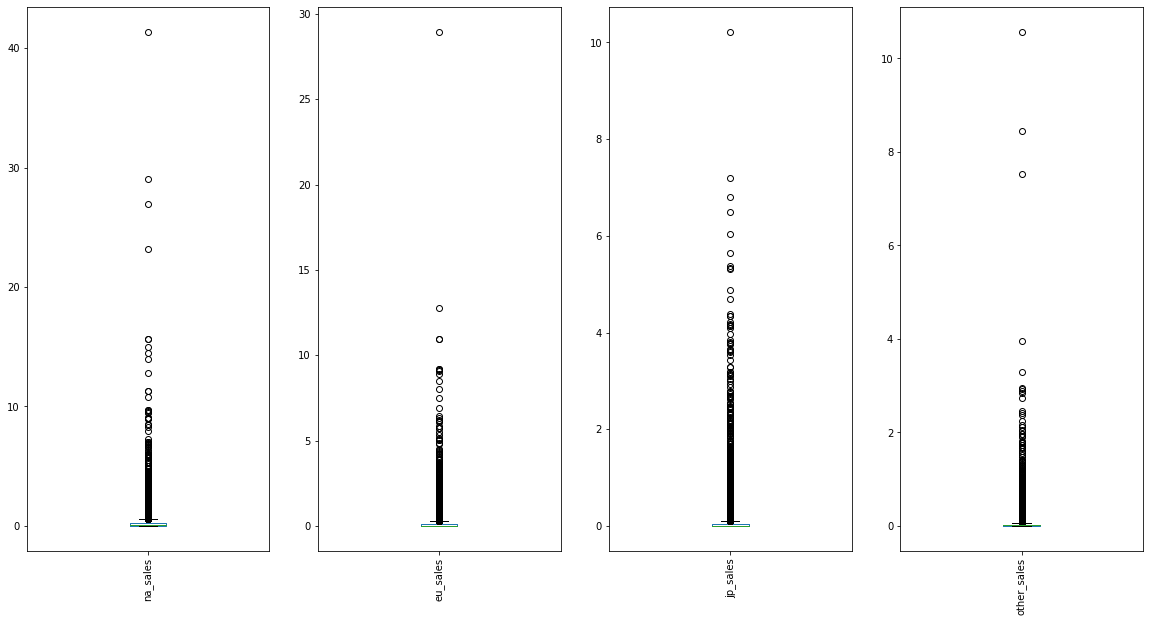

In [45]:
games_df[['na_sales','eu_sales','jp_sales','other_sales']].plot(kind='box',figsize=(20,10),subplots=True,rot = 90);

Немногие игры становятся популярными, из-за чего их количество проданных экземпляров выглядит аномальным.

In [46]:
#Посчитаем суммарные продажи во всех регионах 
games_df['all_sales'] = games_df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [47]:
#Количество удаленных строк
games_df.shape[0]/games_df_shape_old[0]

0.9908465450194436

Удалено менее 1 процента.

#### Вывод по предобработке.

Определены столбцы с пропущенными значениями, и несоответствием типа данных.  
При предобработке данных заполнены пропущенные данные:  
- год выпуска;      
- рейтинг от организации ESRB.

Удалены строки с пропущенными значениями названия игры, года выхода, а также имеющие не распространенные возрастные рейтинги.   

Исправлены типы:  
- год выпуска;  
- оценка пользователей.  
Добавлен столбец с суммарной продажей игр.  


### Проведем исследовательский анализ данных

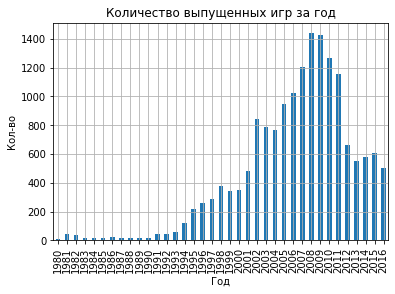

In [49]:
#Построим график выпуска игр за год
games_df.groupby('year_of_release')['name'].count().plot(kind='bar',rot = 90,
                                                         title = 'Количество выпущенных игр за год', xlabel='Год', 
                                                         ylabel='Кол-во',grid=True);


Начиная с 2001 года выпускается больше 400 игр.

Для дальнейшего анализа отсечем годы, когда выпускалось меньше 100 игр.

In [50]:
games_df = games_df[games_df['year_of_release']>=1994]

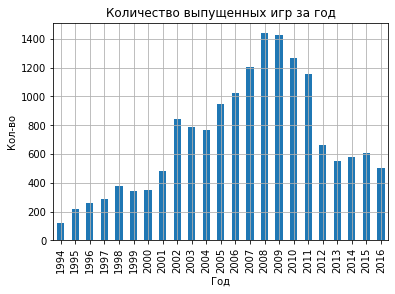

In [51]:
games_df.groupby('year_of_release')['name'].count().plot(kind='bar',rot = 90,
                                                         title = 'Количество выпущенных игр за год', xlabel='Год', 
                                                         ylabel='Кол-во',grid=True);

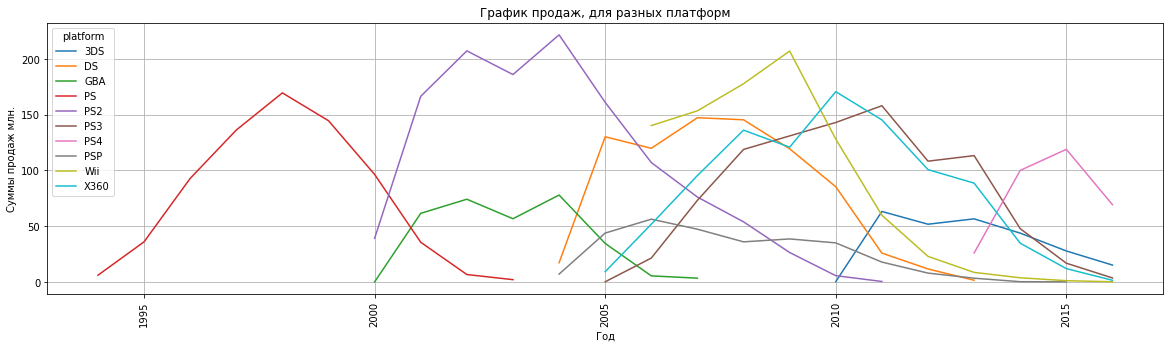

In [52]:
#Посморим как менялись продаж для 10ти наиболее продаваемых платформ
df1 = games_df.groupby(['platform'])['all_sales'].sum().sort_values(ascending=False)
df1 = df1[:10]
df2 = games_df[games_df['platform'].isin(df1.index.tolist())].groupby(['year_of_release','platform'])['all_sales'].sum()
df2.unstack().plot(figsize = (20,5),grid=True,rot=90,xlabel='Год',
                   ylabel='Суммы продаж млн.',title='График продаж, для разных платформ');

 Срок жизни одной платформы 5-7 лет (исключение PC, но его ежегодные продажи не сравнимы с выделлеными платформами).  
 Для составления прогноза на 2017 год возьмем данные за половину срока жизни типичной платформы 2013-2016 год 

In [53]:
games_df_2013_2016 = games_df[games_df['year_of_release']>=2013]

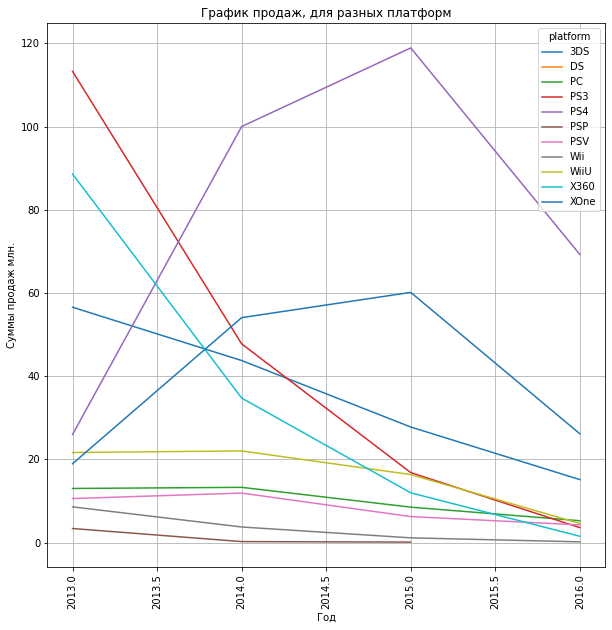

In [54]:
games_df_2013_2016.groupby(['year_of_release','platform'])['all_sales'].sum() \
    .unstack().plot(figsize = (10,10),grid=True,rot=90,xlabel='Год',
                   ylabel='Суммы продаж млн.',title='График продаж, для разных платформ');

Данные за 2016 могут быть неполными, исходя из этого делаем следующие выводы:  
PS4, X360 на восходящем тренде - потенциально прибыльные платформы, этом их продажи уже превышают продажи по другим платформам.      
PC,PSV,WiiU стабильные продажи - сильного изменения не предвидится  
PS3,X360 на нисходяцем тренде - продажи падают  
PSP,Wii - продажи будут очень малы  


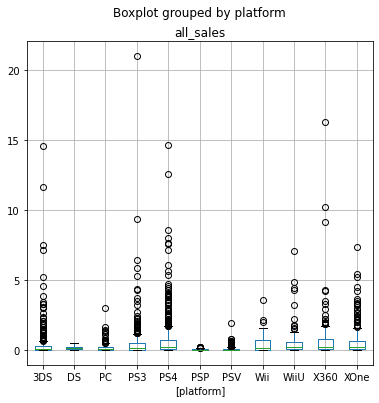

In [55]:
#Построим боксплот по продажам игр в зависимости от платформы
games_df_2013_2016.boxplot(column = ['all_sales'], by = ['platform'],figsize = (6,6));

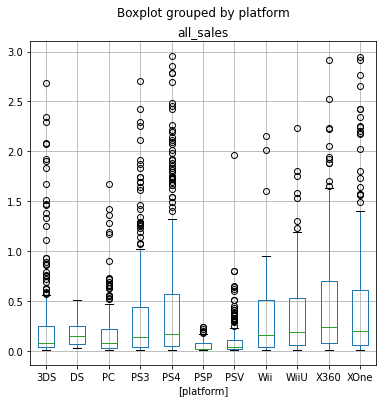

In [56]:
games_df_2013_2016[games_df_2013_2016['all_sales']<3].boxplot(column = ['all_sales'], by = ['platform'],figsize = (6,6));

На всех платформах(кроме DS и PSP) существуют игры продажи которых значительно превышают "усы" распределения продаж.  
Из-за скоса вверх, среднее будет больше медианы.

Т.к. "мы"-интернет-магазин окупаемость разработки врядли важна. Но важно иметь диллерские контракты на игры которые дают прибыль превышающее медианное значение. И строить рекламу вокруг таких проектов-чтобы покупали у "нас".

#### Рассмотрим как влияют отзывы пользователей и критиков на продажи игра платформы PS4.

array([<AxesSubplot:xlabel='Оценка пользователей', ylabel='Суммарные продажи'>],
      dtype=object)

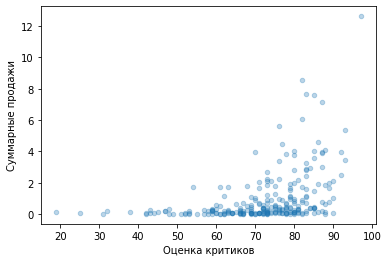

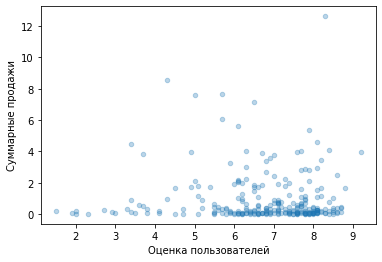

In [57]:
games_df_2013_2016[games_df_2013_2016['platform'] == 'PS4'].plot(x='critic_score', y='all_sales', kind = 'scatter', 
                                                                 subplots=True,xlabel='Оценка критиков',
                                                                 ylabel='Суммарные продажи', alpha=.3)
games_df_2013_2016[games_df_2013_2016['platform'] == 'PS4'].plot(x='user_score', y='all_sales', kind = 'scatter', 
                                                                 subplots=True,xlabel='Оценка пользователей',
                                                                 ylabel='Суммарные продажи', alpha=.3)

In [58]:
print(games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4')]['critic_score'].median())
print(games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4')]['user_score'].median())

73.0
7.0


array([<AxesSubplot:xlabel='Оценка пользователей', ylabel='Суммарные продажи'>],
      dtype=object)

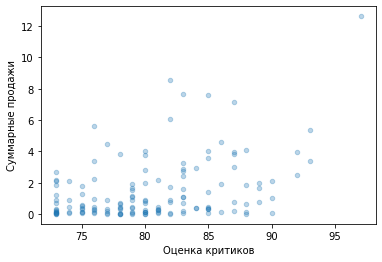

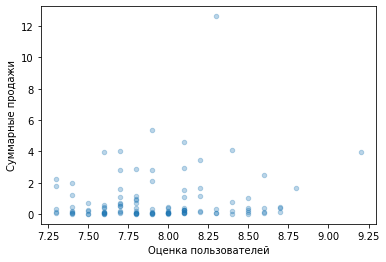

In [59]:
games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4') & (games_df_2013_2016['critic_score']>=73)].plot(x='critic_score', y='all_sales', kind = 'scatter', 
                                                                 subplots=True,xlabel='Оценка критиков',
                                                                 ylabel='Суммарные продажи', alpha=.3)
games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4') & (games_df_2013_2016['user_score']>=7.3)].plot(x='user_score', y='all_sales', kind = 'scatter', 
                                                                 subplots=True,xlabel='Оценка пользователей',
                                                                 ylabel='Суммарные продажи', alpha=.3)

In [61]:
print('Коэффициент корреляции между оценкой критиков и общими продажами для платформы PS4:',
      games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4')]['critic_score'].corr(games_df_2013_2016['all_sales']))
print('Коэффициент корреляции между оценкой пользователей и общими продажами для платформы PS4:',
      games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4')]['user_score'].corr(games_df_2013_2016['all_sales']))
print(len(games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4')]),
      len(games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4') & (games_df_2013_2016['critic_score']>=85)]))
print('Коэффициент корреляции между оценкой критиков и общими продажами для платформы PS4 для высоких оценок:',
      games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4') & (games_df_2013_2016['critic_score']>=85)]['critic_score'].corr(games_df_2013_2016['all_sales']))
print(len(games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4')]),
     len(games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4') & (games_df_2013_2016['user_score']>=8.5)]))
print('Коэффициент корреляции между оценкой пользователей и общими продажами для платформы PS4 для высоких оценок:',
      games_df_2013_2016[(games_df_2013_2016['platform'] == 'PS4') & (games_df_2013_2016['user_score']>=8.5)]['user_score'].corr(games_df_2013_2016['all_sales']))

Коэффициент корреляции между оценкой критиков и общими продажами для платформы PS4: 0.40656790206178095
Коэффициент корреляции между оценкой пользователей и общими продажами для платформы PS4: -0.031957110204556376
392 34
Коэффициент корреляции между оценкой критиков и общими продажами для платформы PS4 для высоких оценок: 0.44224803358373327
392 14
Коэффициент корреляции между оценкой пользователей и общими продажами для платформы PS4 для высоких оценок: 0.7667237954703281


Корреляция между оценкой критиков и продажами слабая, что на всем диапазоне, что при высоких оценках(больше 85), можно не учитывать.
Если рассматривать весь диапазон оценок, то корреляция между оценкой пользователей и продажами отсутствует.
Если смотреть на высокие оценки пользователей (больше 8.5)), то корреляция с продажами значительна, однако из-за малого количества таких игр, нельзя это однознаяно утверждать.


Рассмотрим корреляцию для других платформ.

In [62]:
games_df_2013_2016_platform_list = games_df_2013_2016['platform'].unique().tolist()
platform_corr = dict()
for i in games_df_2013_2016_platform_list:
    platform_corr[i] = ([games_df_2013_2016[(games_df_2013_2016['platform'] == i)]['critic_score'].corr(games_df_2013_2016['all_sales']),
                        games_df_2013_2016[(games_df_2013_2016['platform'] == i) & (games_df_2013_2016['critic_score']>=85)]['critic_score'].corr(games_df_2013_2016['all_sales']),
                        games_df_2013_2016[(games_df_2013_2016['platform'] == i)]['user_score'].corr(games_df_2013_2016['all_sales']),                            
                       games_df_2013_2016[(games_df_2013_2016['platform'] == i) & (games_df_2013_2016['user_score']>=8.5)]['user_score'].corr(games_df_2013_2016['all_sales'])
                        ])

    platform_corr[i] = [round(j,4) for j in platform_corr[i]]

platform_corr_df = pd.DataFrame(platform_corr).T
platform_corr_df.columns = ['critic_score','critic_score>85','user_score','user_score>8.5']
platform_corr_df

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,critic_score,critic_score>85,user_score,user_score>8.5
PS3,0.3343,0.5372,0.0024,0.5775
X360,0.3503,0.7246,-0.0117,-1.0000
PS4,0.4066,0.4422,-0.0320,0.7667
3DS,0.3571,-0.6757,0.2415,0.3682
XOne,0.4170,0.2906,-0.0689,0.6526
WiiU,0.3764,0.2333,0.4193,0.5655
Wii,NaN,NaN,0.6829,NaN
PC,0.1997,0.2739,-0.0900,0.4186
PSV,0.2547,-0.1963,0.0009,-0.0514
DS,NaN,NaN,NaN,NaN


Корреляция между оценкой критиков и продажами слабая.  
Корреляция между оценкой пользователей и продажами отсутствует.

#### Рассмотрим распределение игр по жанрам

In [64]:
games_df_2013_2016.groupby('genre')['all_sales'].sum().sort_values(ascending=False)


genre
Action          322.50
Shooter         232.98
Sports          150.65
Role-Playing    145.89
Misc             63.06
Platform         42.63
Racing           39.89
Fighting         35.31
Adventure        23.64
Simulation       21.76
Strategy         10.08
Puzzle            3.17
Name: all_sales, dtype: float64

Наиболее прибыльные игры жанра Action,Shooter,Sports,Role-Playing.
Наименне прибыльные жанры Strategy,Puzzle

In [65]:
games_df_2013_2016.groupby('genre')['all_sales'].median().sort_values(ascending=False)

genre
Shooter         0.450
Sports          0.240
Platform        0.225
Role-Playing    0.125
Fighting        0.125
Racing          0.120
Action          0.110
Misc            0.105
Simulation      0.100
Strategy        0.080
Puzzle          0.060
Adventure       0.030
Name: all_sales, dtype: float64

In [66]:
games_df_2013_2016.groupby('genre')['all_sales'].mean().sort_values(ascending=False)

genre
Shooter         1.245882
Sports          0.703972
Platform        0.576081
Role-Playing    0.499623
Racing          0.469294
Fighting        0.441375
Action          0.419376
Misc            0.404231
Simulation      0.350968
Puzzle          0.186471
Strategy        0.180000
Adventure       0.096490
Name: all_sales, dtype: float64

По отдельным играм наиболее прибыльные игры жанров Shooter, Sports, Platform.  
Причем их средняя прибыль в разы больше медианной.

### Портрет пользователя по регионам.

#### по платформам

In [67]:
print('NA',games_df_2013_2016.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[0:5])
print('EU',games_df_2013_2016.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[0:5])
print('JP',games_df_2013_2016.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[0:5])

NA platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64
EU platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64
JP platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64


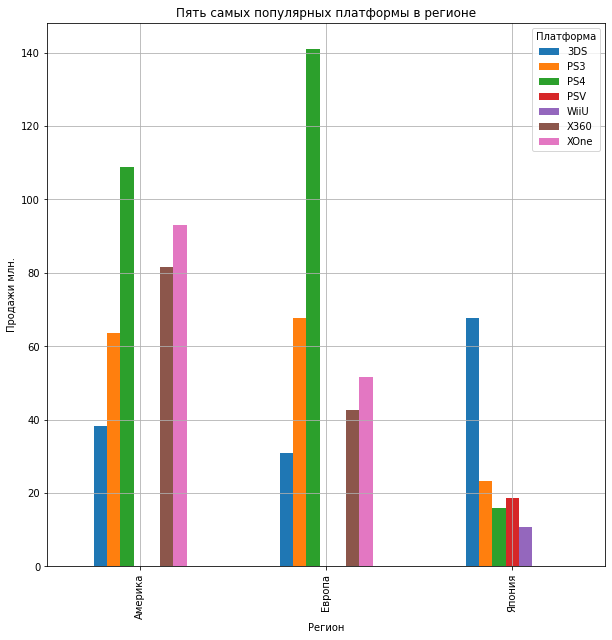

In [87]:
data = dict()
data['Америка'] = games_df_2013_2016.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[0:5]
data['Европа'] = games_df_2013_2016.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[0:5]
data['Япония'] = games_df_2013_2016.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[0:5]
data = pd.DataFrame(data).T

data.plot(kind='bar',figsize = (10,10),xlabel='Регион',ylabel='Продажи млн.',title='Пять самых популярных платформы в регионе', grid=True);
plt.legend(title='Платформа');

В Северной Америке и Европе популярны одинаковые платформы, самая популярная PS4, немного различается только распределение мест в ТОП-5.  
В Японии ТОП-5 кардинально отличается от Европы и Америки, самая популярная 3DS(причем с отрывом в 3 раза), в ТОП-5 отсутствуют XOne,X360.

#### по жанрам

In [88]:
print('NA',games_df_2013_2016.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[0:5])
print('EU',games_df_2013_2016.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[0:5])
print('JP',games_df_2013_2016.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[0:5])

NA genre
Action          126.13
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49
Name: na_sales, dtype: float64
EU genre
Action          118.61
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19
Name: eu_sales, dtype: float64
JP genre
Role-Playing    51.04
Action          40.49
Misc             9.44
Fighting         7.65
Shooter          6.61
Name: jp_sales, dtype: float64


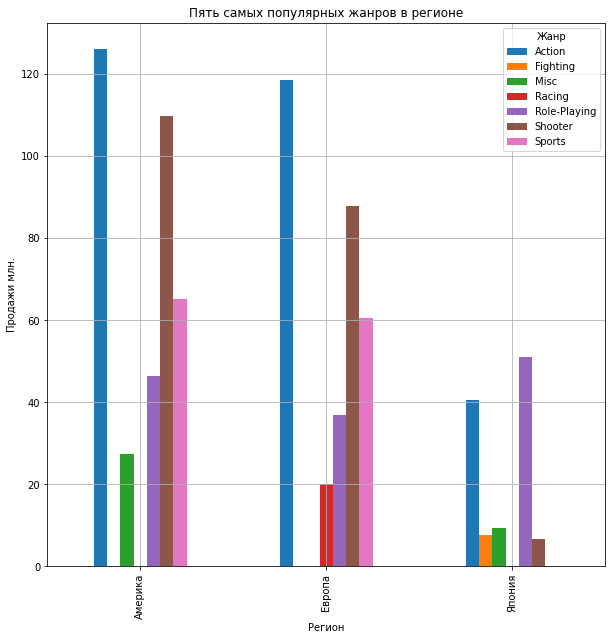

In [91]:
data = dict()
data['Америка'] = games_df_2013_2016.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[0:5]
data['Европа'] = games_df_2013_2016.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[0:5]
data['Япония'] = games_df_2013_2016.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[0:5]
data = pd.DataFrame(data).T

data.plot(kind='bar',figsize = (10,10),xlabel='Регион',ylabel='Продажи млн.',title='Пять самых популярных жанров в регионе', grid=True);
plt.legend(title='Жанр');

Жанры Action,Shooter,Role-Playing присутствуют  во всех ТОП-5. Но даже здесь Япония выделяется - на первом месте Role-Playing, который в остальных топах только на 4м месте.

#### по рейтингу ESRB

In [90]:
print('NA',games_df_2013_2016.groupby('rating')['na_sales'].sum().sort_values(ascending=False)[0:5])
print('EU',games_df_2013_2016.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)[0:5])
print('JP',games_df_2013_2016.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)[0:5])

NA rating
M       165.29
RP       89.42
E        79.05
E10+     54.24
T        49.79
Name: na_sales, dtype: float64
EU rating
M       145.80
E        83.36
RP       78.91
E10+     42.69
T        41.95
Name: eu_sales, dtype: float64
JP rating
RP      85.29
T       20.59
E       15.14
M       14.11
E10+     5.89
Name: jp_sales, dtype: float64


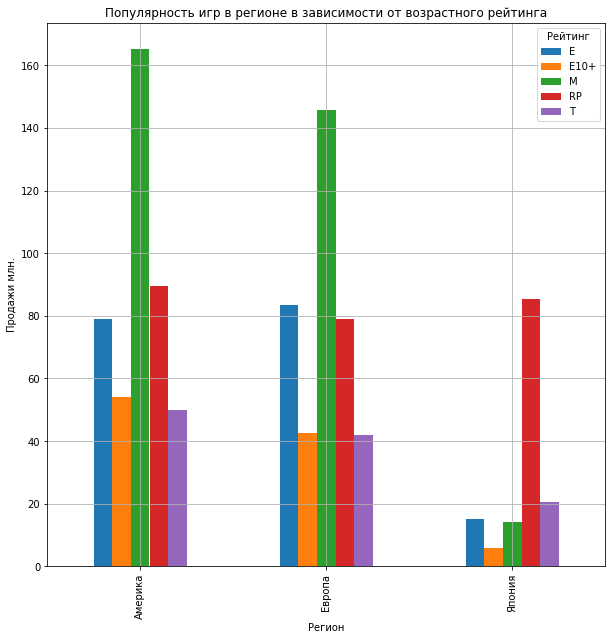

In [92]:
data = dict()
data['Америка'] = games_df_2013_2016.groupby('rating')['na_sales'].sum().sort_values(ascending=False)[0:5]
data['Европа'] = games_df_2013_2016.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)[0:5]
data['Япония'] = games_df_2013_2016.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)[0:5]
data = pd.DataFrame(data).T

data.plot(kind='bar',figsize = (10,10),xlabel='Регион',ylabel='Продажи млн.',title='Популярность игр в регионе в зависимости от возрастного рейтинга', grid=True);
plt.legend(title='Рейтинг');

В Европе и Америке опять одинаковые топы, на первом месте рейтинг М-для взрослых(довольно сильное ограничение).  
При этом значительные продажи имеют игры Юез рейтинга(RP). И если для Японии это объяснимо (ESRB -организация из Америки).   Наличие в Европе и тем более в Америке игр без рейтинга на 2м месте, приводит к выводу, что данный рейтинг не сильно влияет на продажи.

#### Промежиточный итог:  
Европа и Америка похожи по своим предпочтениям.
Япония от них очень отличается.
Соответственно для Европы и Америки можно объединить ассортимент, рекламные компании, для Японии необходимо разрабатывать отдельно, исходя из особенностей данного рынка.

### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковы

Нулевая гипотеза - средние рейтинги равны.  
Альтернативная - средние рейтинги отличаются.

In [103]:

list_xone = games_df_2013_2016[games_df_2013_2016['platform'] == 'XOne']['user_score'].tolist()
list_pc = games_df_2013_2016[games_df_2013_2016['platform'] == 'PC']['user_score'].tolist()

alpha = 0.01
results = st.ttest_ind(list_xone,list_pc,nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15503167687396294
Не получилось отвергнуть нулевую гипотезу


Принимаем гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Нулевая гипотеза - средние рейтинги равны.  
Альтернативная - средние рейтинги отличаются.

In [105]:
#Нулевая гипотеза-рейтинги равны
list_action = games_df_2013_2016[games_df_2013_2016['genre'] == 'Action']['user_score'].tolist()
list_sports = games_df_2013_2016[games_df_2013_2016['genre'] == 'Sports']['user_score'].tolist()

alpha = 0.01
results = st.ttest_ind(list_action,list_sports,nan_policy='omit')

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.117296239191993e-28
Отвергаем нулевую гипотезу


Принимаем гипотезу о том что, средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Общие выводы
После получения данных, произведен их первичный анализ.  
Определены столбцы с пропущенными значениями, и несоответствием типа данных.  
При предобработке данных заполнены пропущенные данные:  
- год выпуска;      
- рейтинг от организации ESRB.  
Удалены строки с пропущенными значениями названия игры, года выхода, а также имеющие не распространённые возрастные рейтинги.   
Исправлены типы:  
- год выпуска;  
- оценка пользователей.  
Добавлен столбец с суммарной продажей игр.  

При исследовании данных установлено:  
- средний срок жизни платформы 5-7 лет;  
- наиболее потенциально прибыльные платформы в 2017 это PS4 и X360;  
- взаимосвязь между оценками пользователей продажами не обнаружено;  
- взаимосвязь между оценкой критиков и продажами слабая;  
- наиболее прибыльные игры жанров Shooter, Sports, Platform.;  
- продажи в Японии сильно отличаются от Америки и Европы, как по платформам так и по жанрам игр;  
- рейтинг ESRB не влияет на продажи игр.
- для Европы и Америки можно объединить ассортимент, рекламные компании, для Японии необходимо разрабатывать отдельно, исходя из особенностей данного рынка.  

Проверили гипотезы и сделали вывод:  
- средние пользовательские рейтинги платформ Xbox One и PC одинаковы.
- средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.  
 
